In [145]:
micromamba activate scvelo_jupyter_new
micromamba run -n scvelo_jupyter_new pip install rds2py
micromamba run -n scvelo_jupyter_new pip install twine
micromamba run -n scvelo_jupyter pip install git+https://github.com/furlan-lab/pyviewmaster.git
micromamba run -n scvelo_jupyter pip install plotly==5.24.1
micromamba run -n scvelo_jupyter pip install colorcet

SyntaxError: invalid syntax (483409841.py, line 1)

In [148]:
# Core scverse libraries
import scanpy as sc
import anndata as ad
import scvelo as scv
import os
import glob
import pandas as pd
import numpy as np
sc.settings.set_figure_params(dpi=100, facecolor="white")
import socket
from pyviewmaster import *
import seaborn as sns
import colorcet as cc

hostname = socket.gethostname()

if hostname.startswith("gizmo"):
  ROOT_DIR1 = "/fh/fast/furlan_s/datasets/AML/LOR_classifier/cds"
  ROOT_DIR2 = "/fh/fast/furlan_s/grp/data/ddata/BM_data"
else:
  ROOT_DIR1 = "/Users/sfurlan/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerCenter/Furlan_Lab - General/datasets/AML/LOR_classifier/cds"
  ROOT_DIR2 = "/Users/sfurlan/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerCenter/Furlan_Lab - General/experiments/patient_marrows/WC1/cds"


## LOAD SUMMARIZED EXPERIMENT OBJECT IN PYTHON

In [124]:
from rds2py import read_rds
ref =read_rds(ROOT_DIR1+"/240126_Combined_SE_Object.RDS")


In [125]:
coldata = get_coldata_rds_obj(ref)
coldata.set_index = coldata["rownames"]
rowdata = get_rowdata_rds_obj(ref)
rowdata.set_index = rowdata["gene_short_name"]
scounts = get_counts_rds_obj(ref)

In [126]:
rdata = ad.AnnData(scounts)
rdata.obs = coldata
rdata.var = rowdata
rdata.obs_names = coldata.index
rdata.var_names = rowdata.index
rdata.layers["counts"] = rdata.X.copy()

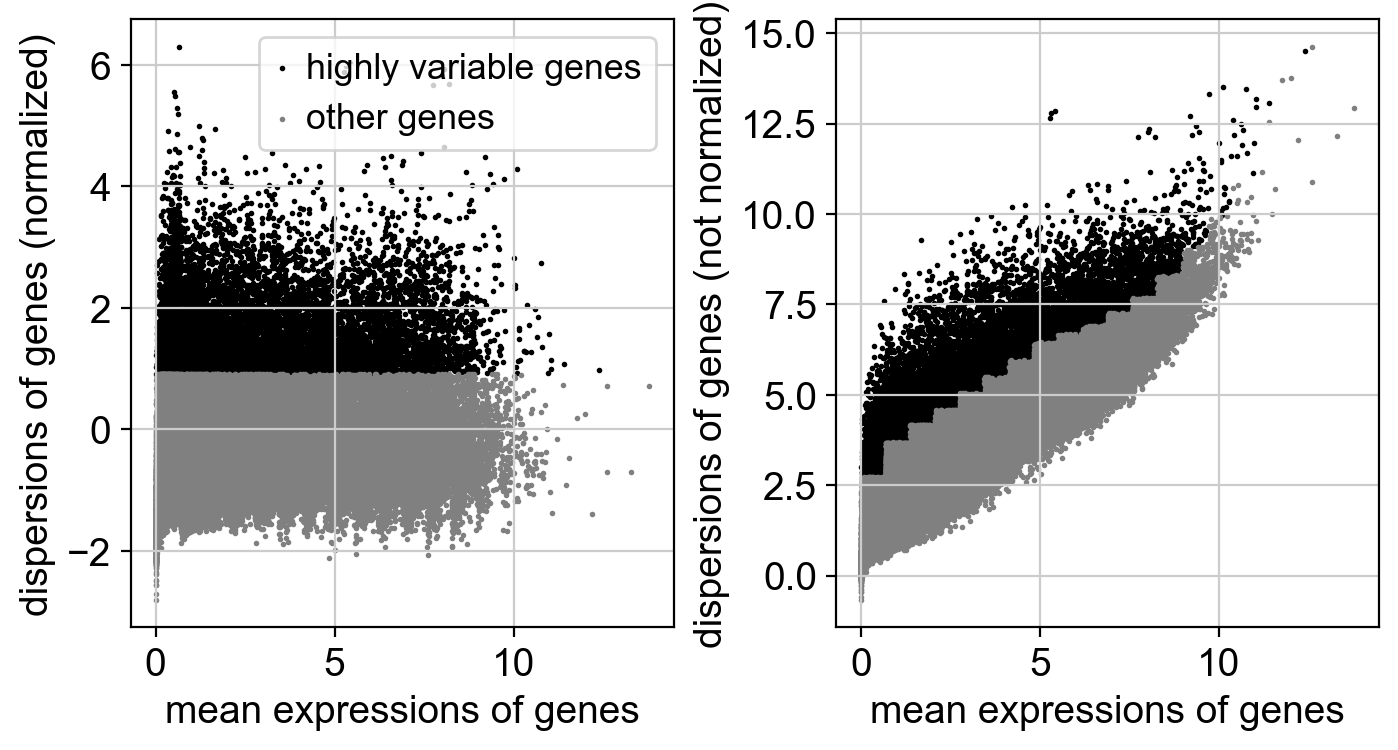

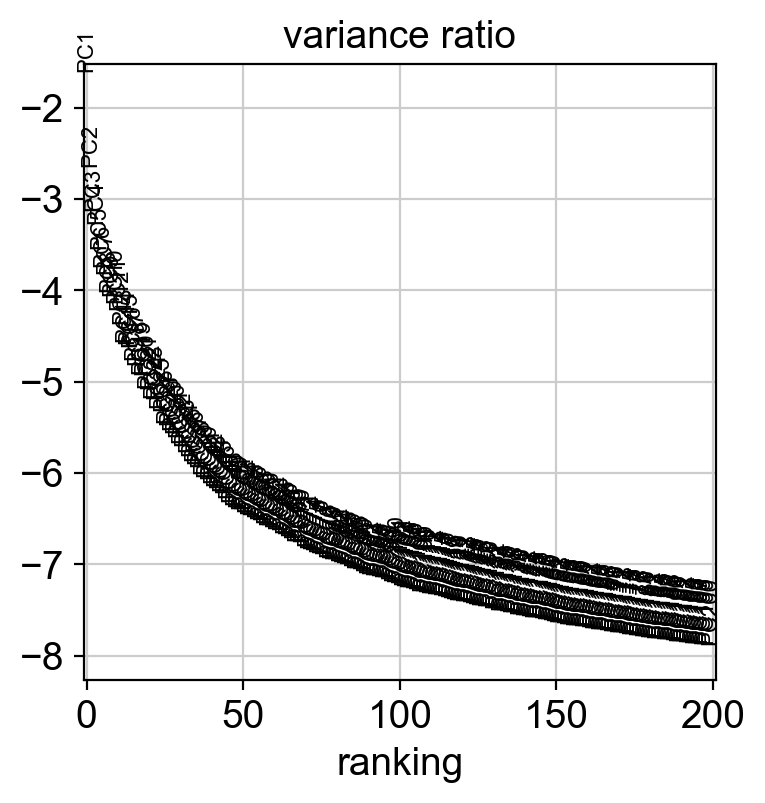

In [127]:
sc.pp.normalize_total(rdata)
sc.pp.log1p(rdata)
sc.pp.highly_variable_genes(rdata, n_top_genes=10000)
sc.pl.highly_variable_genes(rdata)
sc.tl.pca(rdata, n_comps=200)
sc.pl.pca_variance_ratio(rdata, n_pcs=200, log=True)


In [128]:
sc.pp.neighbors(rdata, n_pcs=200)


In [129]:
sc.tl.umap(rdata, min_dist=0.4, n_components=3)


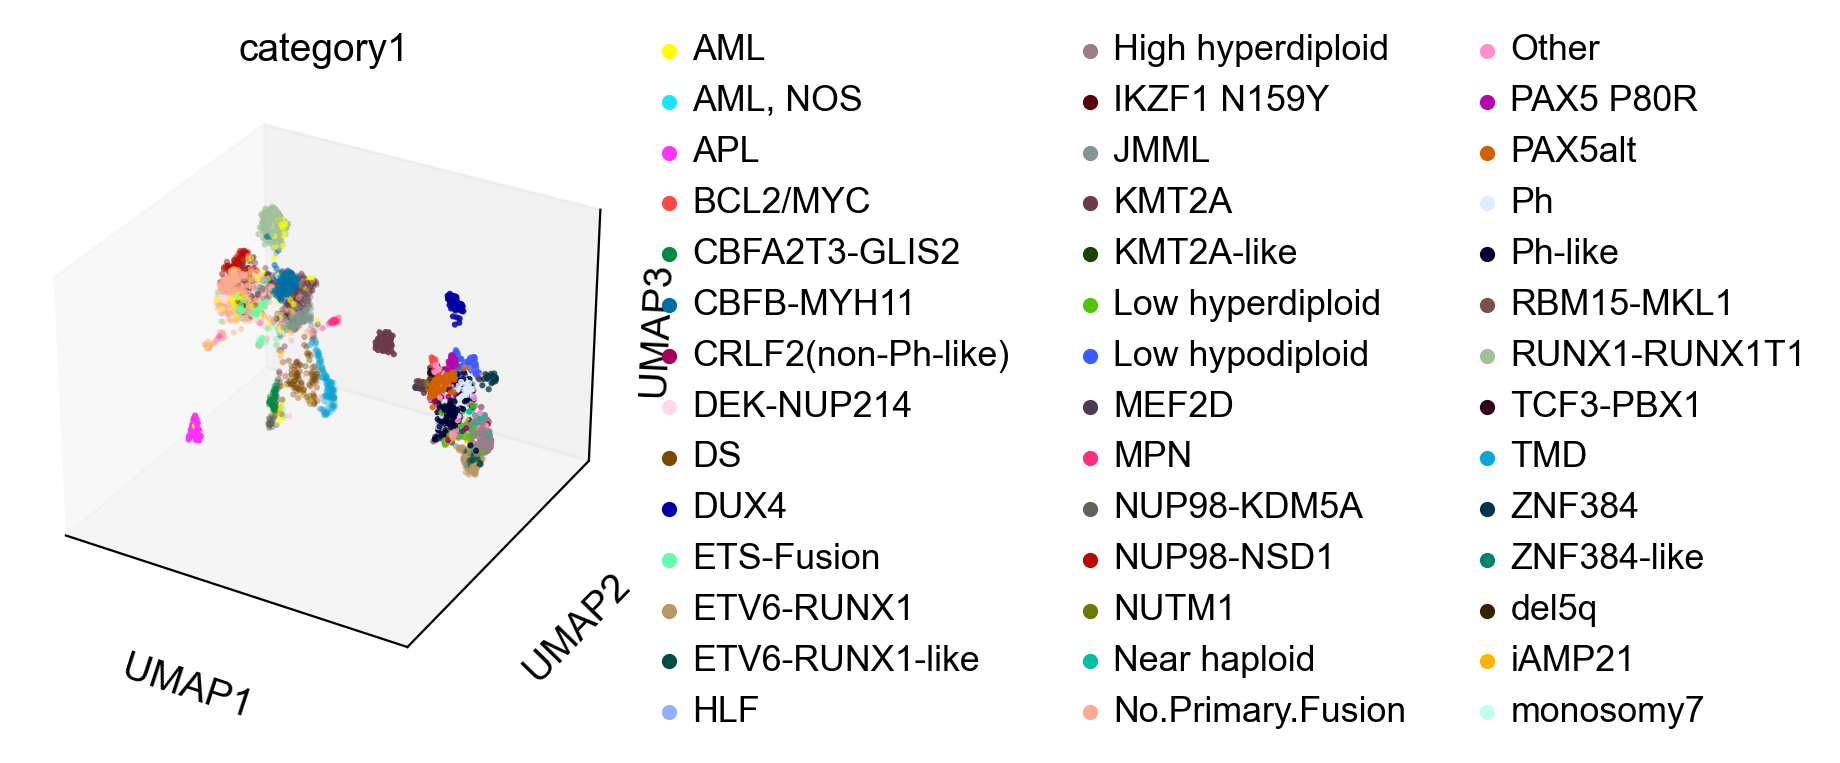

In [130]:
sc.pl.umap(rdata, color = "category1", projection = "3d")

In [161]:
palette = sns.color_palette(cc.glasbey, n_colors=50, as_cmap=True)

In [162]:
df = rdata.obsm['X_umap']
df = pd.DataFrame(df)
df.columns = ["umap1", "umap2", "umap3"]
df["category1"] = rdata.obs["category1"].values
df.index = rdata.obs.index
fig = px.scatter_3d(df, x='umap1', y='umap2', z='umap3',
              color='category1', color_discrete_sequence = palette)
fig.update_traces(marker_size = 1.5)
fig.show()


## LOAD QUERY

In [163]:
adata = sc.read_loom(ROOT_DIR2+"/WC_velocity.loom")

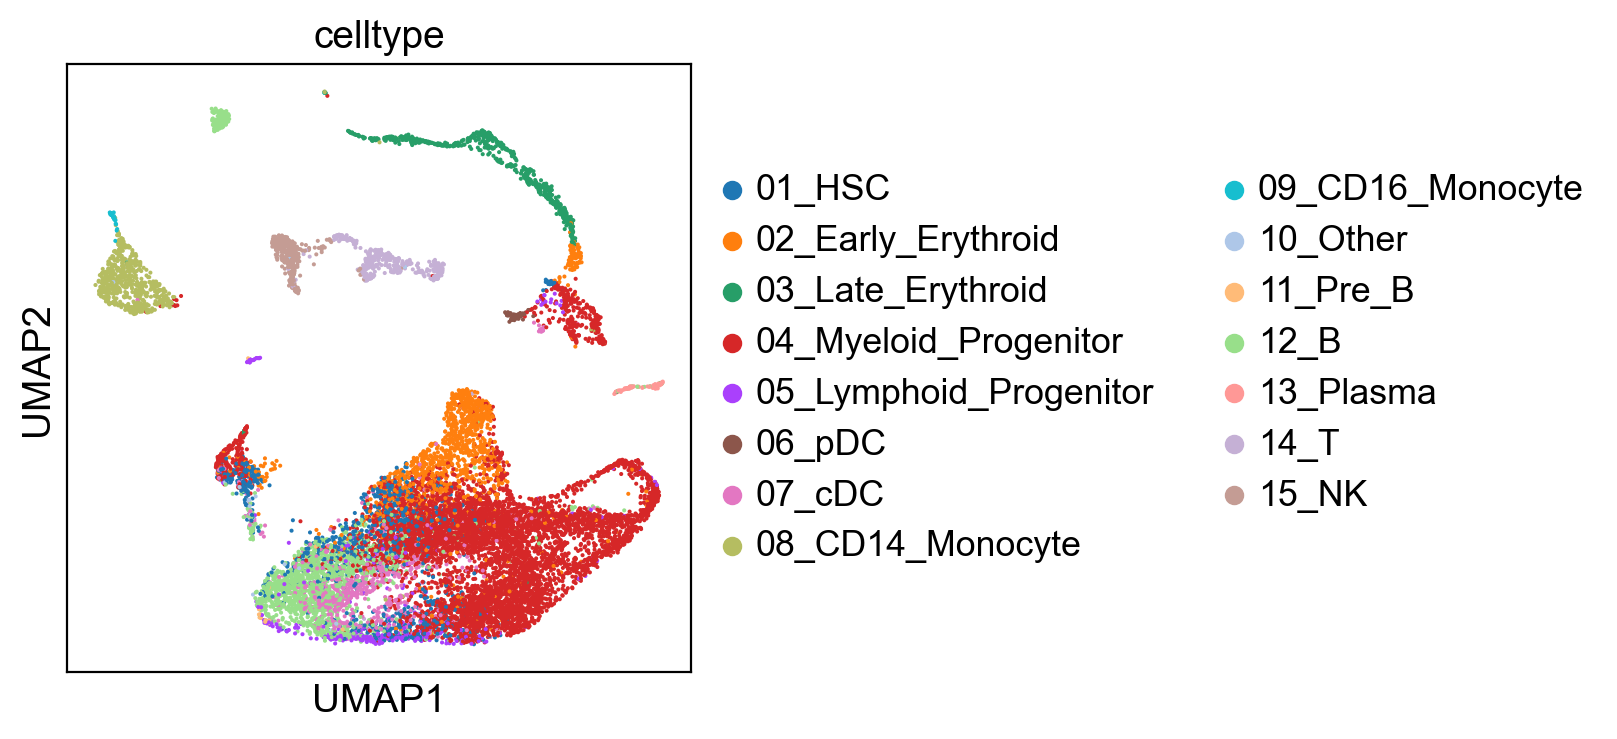

In [164]:
sc.pl.umap(adata, color = "celltype")

In [165]:
query = adata
ref = rdata
assay=None
counts_query = get_counts_adata(query, layer="matrix")
sizes = sum_counts(counts_query, axis=1)
n = len(sizes)
sd_sizes = np.std(sizes, ddof=1)
IQR_sizes = np.subtract(*np.percentile(sizes, [75, 25]))
bw = 0.9 * min(sd_sizes, IQR_sizes / 1.34) * n ** (-1/5)



In [166]:

genes_query = query.var_names
genes_ref = ref.var['gene_short_name'].values
universe = np.intersect1d(genes_ref, genes_query)


In [167]:

bulk_feature_row_values = ref.var['gene_short_name'].values
gene_to_idx = {gene: idx for idx, gene in enumerate(bulk_feature_row_values)}
indices = [gene_to_idx[gene] for gene in universe]

In [168]:

counts_ref_full = get_counts_adata(ref, layer="counts")
counts = counts_ref_full[:, indices]
gene_names = universe

min_size = sizes.min()
max_size = sizes.max()

AttributeError: 'csr_matrix' object has no attribute 'index'

In [242]:

# Generate newsizes array with random choice and added Gaussian noise
newsizes = np.random.choice(sizes, N * 10, replace=True) + np.random.normal(0, den_bw, N * 10)
# Filter and round
trimmed_newdata = np.round(newsizes[(newsizes > min_size) & (newsizes < max_size)]).astype(int)
# Choose final sizes without replacement and ensure integer type
final_newsizes = np.random.choice(trimmed_newdata, N, replace=False)
# Get row data as a flattened 1D array
rowdata = counts[n, :].todense().A1  # Use .A1 directly on the sparse matrix for flattening
# Efficiently replicate gene names based on counts using np.repeat
replicated_array = np.repeat(gene_names, rowdata).tolist()


In [183]:

from multiprocessing import Pool, cpu_count


# Assuming the following variables are defined:
# sizes: 1D numpy array or list of sizes
# N: integer
# den_bw: float (equivalent to den$bw in R)
# counts: pandas DataFrame with rows and columns similar to the R counts matrix
# universe: list or array of all possible names (equivalent to 'universe' in R)
# replace_counts: boolean indicating whether to sample with replacement
# ref: pandas DataFrame or numpy array (used to get its shape)

def worker(n):
    # Generate newsizes by sampling from sizes and adding normally distributed noise
    newsizes = np.random.choice(sizes, N * 10, replace=True) + np.random.normal(0, bw, N * 10)
    
    # Trim newsizes to be within the min and max of sizes and round to nearest integer
    trimmed_newdata = np.round(newsizes[(newsizes > np.min(sizes)) & (newsizes < np.max(sizes))])
    
    # Sample final newsizes without replacement
    final_newsizes = np.random.choice(trimmed_newdata, N, replace=False)
    
    # Get the nth row from counts
    rowdata = counts.iloc[n,:]
    
    # Repeat index values according to the counts in rsums
    splat = rowdata.index.repeat(rowdata.values.astype(int))
    
    # Inner function to generate the data list
    def inner_func(i):
        # Sample from splat
        sampled = np.random.choice(splat, int(i), replace=replace_counts)
        
        # Create a frequency table of the sampled data
        tab = pd.Series(sampled).value_counts()
        
        # Find names not in the frequency table
        nf = [u for u in universe if u not in tab.index]
        
        # Combine the frequency table with zeros for the missing names
        zeros = pd.Series([0]*len(nf), index=nf)
        all_counts = pd.concat([tab, zeros])
        
        # Reorder counts to match the universe
        all_counts = all_counts.loc[universe]
        return all_counts
    
    # Apply the inner function to each size in final_newsizes
    dl = [inner_func(i) for i in final_newsizes]
    
    # Combine the list into a DataFrame and convert to a sparse matrix
    result = pd.concat(dl, axis=1).fillna(0)
    return sparse.csc_matrix(result.values)



<2979x35721 sparse matrix of type '<class 'numpy.int32'>'
	with 78219935 stored elements in Compressed Sparse Row format>

In [169]:



def process_sample(args):
    n, counts_n = args
    rsums = counts_n
    rsums = pd.Series(rsums, index=gene_names)
    counts_gt0 = rsums[rsums > 0]
    if len(counts_gt0) == 0:
        warnings.warn(f"Sample {n} has no counts > 0.")
        return None
    splat_genes = counts_gt0.index.values
    splat_counts = counts_gt0.values.astype(int)
    splat = np.repeat(splat_genes, splat_counts)
    newsizes = np.random.choice(sizes, N, replace=True) + np.random.normal(0, bw, N)
    newsizes = newsizes[(newsizes > min_size) & (newsizes < max_size)]
    if len(newsizes) == 0:
        warnings.warn(f"No valid newsizes for sample {n}.")
        return None
    final_newsizes = np.random.choice(np.round(newsizes), N)
    dl = []
    for i in final_newsizes:
        sample_counts = np.random.choice(splat, int(i), replace=replace_counts)
        tab = pd.value_counts(sample_counts)
        all_counts = tab.reindex(gene_names, fill_value=0)
        dl.append(all_counts.values)
    return np.column_stack(dl)


In [182]:

args_list = []
n = 1
counts_n = counts[n, :].toarray().flatten()
print(counts_n)

[  59  167    8 ... 4538    0    0]


In [ ]:

for n in range(1):
    counts_n = counts[n, :].toarray().flatten() if scipy.sparse.issparse(counts) else counts[n, :]
    args_list.append((n, counts_n))
args_list

In [ ]:

with Pool() as pool:
    results = pool.map(process_sample, args_list)


In [ ]:

# Filter out None results
good_results = [res for res in results if res is not None]

if not good_results:
    raise ValueError("No valid data generated.")

# Concatenate data
data = np.concatenate(good_results, axis=1)

# Create metadata
metai = np.repeat(np.arange(counts.shape[1]), N)
meta = ref.obs.reset_index(drop=True)
newmeta = meta.iloc[metai, :].reset_index(drop=True)

# Create anndata object
adata_new = anndata.AnnData(X=data.T, var=pd.DataFrame(index=gene_names), obs=newmeta)


In [ ]:
sc.pl.umap(adata, color = "ground_truth", palette = cols2)

## find variable genes

In [ ]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
sc.pp.highly_variable_genes(adata,  n_top_genes=10000)
sc.pp.highly_variable_genes(adata,  n_top_genes=10000)
vg = intersection(adata.var.index[adata.var['highly_variable'].to_numpy()].tolist(), rdata.var.index[rdata.var['highly_variable'].to_numpy()].tolist())

In [ ]:
viewmaster(adata, rdata, "SFClassification", query_celldata_col= "vmP_mlr", FUNC= "mlr", selected_genes=vg)
viewmaster(adata, rdata, "SFClassification", query_celldata_col= "vmP_nb", FUNC= "nb", selected_genes=vg)
viewmaster(adata, rdata, "SFClassification", query_celldata_col= "vmP_nn", FUNC= "nn", selected_genes=vg)

In [ ]:
sc.pl.umap(adata, color = "vmP_mlr", palette = cols2)
sc.pl.umap(adata, color = "vmP_nb", palette = cols2)
sc.pl.umap(adata, color = "vmP_nn", palette = cols2)
sc.pl.umap(adata, color = "ground_truth", palette = cols2)